# chatbot with Transformer

Building a chatbot by implementing the transformer model using oop
The model is effective for performing the task due to its ability to perform the recognition independently of the previous word - this contributes to the prevention of gradient vanishing during the training

The execution stages were:
1) process data 
2) Creating the model classes to implement the architecture
3) Training and evaluation

In [ ]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.utils.data
import math
import torch.nn.functional as F
from collections import Counter

In [ ]:
#Loading the data and preparing it by separating the questions and the answers

corpus_movie_conv = 'archive/movie_conversations.txt'
corpus_movie_lines = 'archive/movie_lines.txt'
max_len = 25

In [ ]:
with open(corpus_movie_conv, 'r') as c:
    conv = c.readlines()
with open(corpus_movie_lines, 'r',encoding = "ISO-8859-1") as l:
    lines = l.readlines()

In [ ]:
lines_dic = {}
for line in lines:
    objects = line.split(" +++$+++ ")
    lines_dic[objects[0]] = objects[-1]

In [ ]:
def remove_punc(string):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in string:
        if char not in punctuations:
            no_punct = no_punct + char  
    return no_punct.lower()

In [ ]:
pairs = []
for con in conv:
    ids = eval(con.split(" +++$+++ ")[-1])
    for i in range(len(ids)-1):
        qa_pairs = []
        first = remove_punc(lines_dic[ids[i]].strip())      
        second = remove_punc(lines_dic[ids[i+1]].strip())
        qa_pairs.append(first.split()[:max_len])
        qa_pairs.append(second.split()[:max_len])
        pairs.append(qa_pairs)

In [ ]:
word_freq = Counter()
for pair in pairs:
    word_freq.update(pair[0])
    word_freq.update(pair[1])

In [ ]:
min_word_freq = 5
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0

In [ ]:
print("Total words are: {}".format(len(word_map)))

In [ ]:
with open('WORDMAP_corpus.json', 'w') as j:
    json.dump(word_map, j)

In [ ]:
def encode_question(words, word_map):
    enc_c = [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

In [ ]:
def encode_reply(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + \
    [word_map['<end>']] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

In [ ]:
pairs_encoded = []
for pair in pairs:
    ques = encode_question(pair[0],word_map)
    reply = encode_reply(pair[1],word_map)
    pairs_encoded.append([ques,reply])

In [ ]:
with open('pairs_encoded.json', 'w') as p:
    json.dump(pairs_encoded, p)

In [ ]:
class Dataset(Dataset):

    def __init__(self):

        self.pairs = json.load(open('pairs_encoded.json'))
        self.dataset_size = len(self.pairs)

    def __getitem__(self, i):
        
        question = torch.LongTensor(self.pairs[i][0])
        reply = torch.LongTensor(self.pairs[i][1])
            
        return question, reply

    def __len__(self):
        return self.dataset_size

In [ ]:
train_loader = torch.utils.data.DataLoader(Dataset(),
                                           batch_size = 100, 
                                           shuffle=True, 
                                           pin_memory=True)

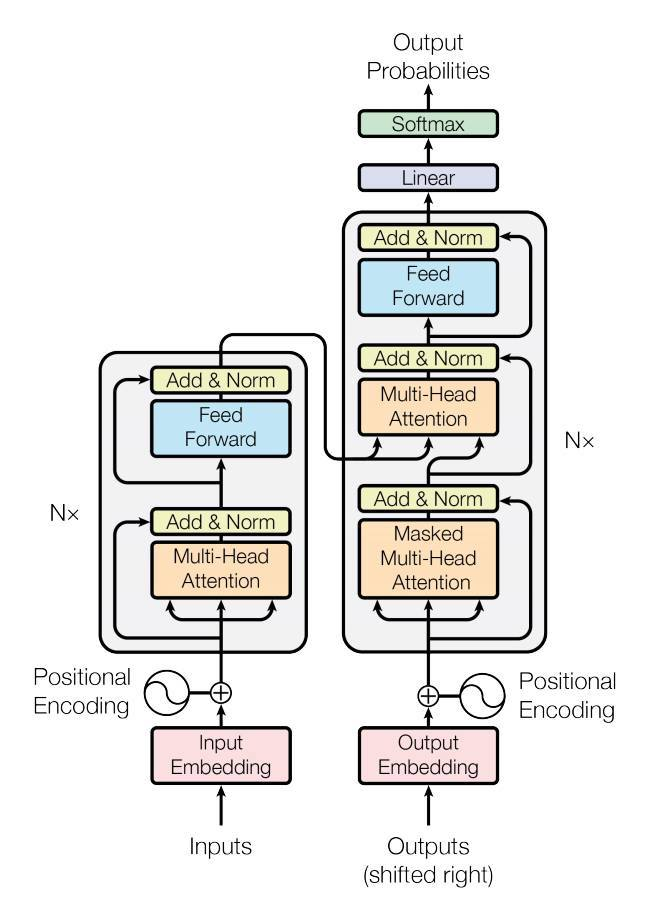

In [ ]:
#start to defining the model class
def create_masks(question, reply_input, reply_target):  
    
    def subsequent_mask(size):
        mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        return mask.unsqueeze(0)
    
    question_mask = question!=0
    question_mask = question_mask.unsqueeze(1).unsqueeze(1)         
     
    reply_input_mask = reply_input!=0
    reply_input_mask = reply_input_mask.unsqueeze(1)  
    reply_input_mask = reply_input_mask & subsequent_mask(reply_input.size(-1)).type_as(reply_input_mask.data) 
    reply_input_mask = reply_input_mask.unsqueeze(1) 
    reply_target_mask = reply_target!=0              
    
    return question_mask, reply_input_mask, reply_target_mask

if i even the position difun by sin()
         if i odd the position difun by cos()

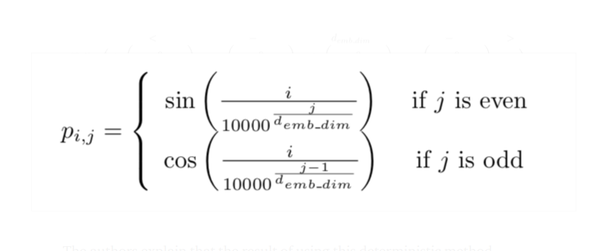

In [ ]:
class Embeddings(nn.Module):
    
    def __init__(self, vocab_size, d_model, max_len = 50,num_layers = 6):
        super(Embeddings,self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(0.1)
        self.embed = nn.Embedding(vocab_size, d_model)
        self.te = self.positinal_encoding(num_layers, self.d_model)
        self.pe = self.positinal_encoding(max_len, self.d_model)
    
    def positinal_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        for pos in range(max_len):  
            for i in range(0, d_model, 2):  
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))             
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)   
        return pe
                                       
    def forward(self,embeddings,indax_layer):
        if indax_layer == 0:
            embeddings = self.embed(embeddings) * math.sqrt(self.d_model)
        embeddings += self.pe[:,:embeddings.size(1),:]
        embeddings += self.te[:,indax_layer, :].unsqueeze(1).repeat(1, embeddings.size(1), 1)
        embeddings = self.dropout(embeddings)
        return embeddings

difining class for molti head attention and implmanting the formula

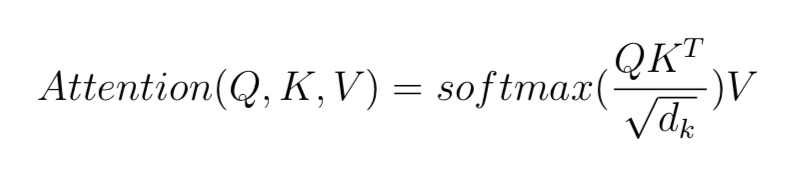



In [ ]:

class MoltiHeadAttention(nn.Module):
    
    def __init__(self,heads,d_model):
        super(MoltiHeadAttention,self).__init__()
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.head = heads
        self.dropout = nn.Dropout(0.1)
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.concat = nn.Linear(d_model, d_model)
        
    def forward(self,query,key,value,mask):
        query = self.query(query)
        key = self.key(key)
        value = self.value(value)
        query = query.view(query.shape[0],-1,self.head,self.d_k).permute(0,2,1,3)
        key = key.view(key.shape[0], -1, self.head, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.head, self.d_k).permute(0, 2, 1, 3)
        scores = torch.matmul(query,key.permute(0,1,3,2)) / math.sqrt(query.size(-1))
        scores = scores.masked_fill(mask==0,-1e9)
        weights = F.softmax(scores, dim = -1)
        weights = self.dropout(weights)
        z = torch.matmul(weights,value)
        z = z.permute(0,2,1,3).contiguous().view(z.shape[0], -1, self.head * self.d_k)
        interacted = self.concat(z)
        return interacted

In [ ]:
class FeedForward(nn.Module):
    
    def __init__(self, d_model, hid_dim = 2048):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model , hid_dim)
        self.fc2 = nn.Linear(hid_dim,d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

**difining the Encoder and Decoder class**

In [ ]:
class EncoderLayer(nn.Module):
    
    def __init__(self,d_model,heads):
        super(EncoderLayer,self).__init__()
        self.self_multihead = MoltiHeadAttention(heads,d_model)
        self.feed_forward = FeedForward(d_model)
        self.layernorm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self,embeddings,mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted+embeddings)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

In [ ]:
class DecoderLayer(nn.Module):
    
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MoltiHeadAttention(heads, d_model)
        self.src_multihead = MoltiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self,embeddings, encoded, src_mask, target_mask):
        query = self.dropout(self.self_multihead(embeddings,embeddings,embeddings,target_mask))
        query = self.layernorm(query + embeddings)
        interacted = self.dropout(self.src_multihead(query,encoded,encoded,src_mask))
        interacted = self.layernorm(interacted + query)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        decoded = self.layernorm(feed_forward_out + interacted)
        return decoded

**implementing fall Transformer Like the picture above**

In [ ]:
class Transformer(nn.Module):
    
    def __init__(self, d_model, heads, num_layers, word_map):
        super(Transformer, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.vocab_size = len(word_map)
        self.embed = Embeddings(self.vocab_size, d_model, num_layers = num_layers)
        self.encoder = EncoderLayer(d_model, heads) 
        self.decoder = DecoderLayer(d_model, heads)
        self.logit = nn.Linear(d_model, self.vocab_size)
        
    def encode(self, src_embeddings, src_mask):
        for i in range(self.num_layers):
            src_embeddings = self.embed(src_embeddings, i)
            src_embeddings = self.encoder(src_embeddings, src_mask)
        return src_embeddings
    
    def decode(self, tgt_embeddings, target_mask, src_embeddings, src_mask):
        for i in range(self.num_layers):
            tgt_embeddings = self.embed(tgt_embeddings,i)
            tgt_embeddings = self.decoder(tgt_embeddings, src_embeddings, src_mask, target_mask)
        return tgt_embeddings
        
    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded = self.encode(src_words, src_mask)
        decoded = self.decode(target_words, target_mask, encoded, src_mask)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out

It is useful to implement the lr warmup method. A class has been defined for the optimizer and the formula is implemented in it:

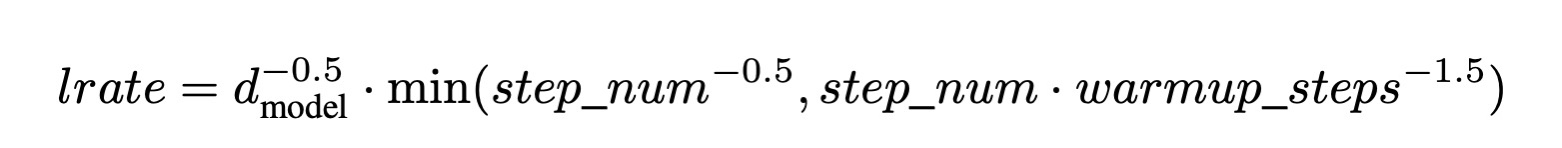

In [ ]:
class AdamWarmup:
    
    def __init__(self, model_size, warmup_steps, optimizer):
        self.model_size = model_size
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.current_step = 0 
        self.lr = 0
        
    def get_lr(self):
        return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_steps ** (-1.5))
    
    def step(self):
        self.current_step +=1
        lr = self.get_lr()
        for pg in self.optimizer.param_groups:
            pg["lr"] = lr
        self.lr = lr
        self.optimizer.step()
        

In [ ]:
class LossWithLS(nn.Module):

    def __init__(self, size, smooth):
        super(LossWithLS, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False,reduce=False)
        self.confidence = 1.0-smooth
        self.smooth = smooth
        self.size = size
        
    def forward(self,prediction, target, mask):
        prediction = prediction.view(-1,prediction.size(-1))
        target = target.contiguous().view(-1)
        mask = mask.float()
        mask = mask.view(-1) 
        labels = prediction.data.clone()
        labels.fill_(self.smooth / (self.size -1))
        labels.scatter_(1, target.data.unsqueeze(1), self.confidence)
        loss = self.criterion(prediction, labels)    
        loss = (loss.sum(1) * mask).sum() / mask.sum()
        return loss

In [ ]:
#difining Hyperparameter
d_model = 512  
heads = 8
num_layers = 1
epochs = 10

with open('WORDMAP_corpus.json', 'r') as j:
    word_map = json.load(j)
    
transformer = Transformer(d_model = d_model, heads = heads, num_layers = num_layers, word_map = word_map)
adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = d_model, warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(len(word_map), 0.1)

In [ ]:
#trining matod
def train(train_loader, transformer, criterion, epoch):
    
    transformer.train()
    sum_loss = 0
    count = 0

    for i, (question, reply) in enumerate(train_loader):
        
        samples = question.shape[0]
        reply_input = reply[:, :-1]
        reply_target = reply[:, 1:]
        question_mask, reply_input_mask, reply_target_mask = create_masks(question, reply_input, reply_target)
        out = transformer(question, question_mask, reply_input, reply_input_mask)
        
        loss = criterion(out, reply_target, reply_target_mask)
        transformer_optimizer.optimizer.zero_grad()
        loss.backward()
        transformer_optimizer.step()
        
        sum_loss += loss.item() * samples
        count += samples
        
        if i % 100 == 0:
            print("Epoch [{}][{}/{}]\tLoss: {:.3f}".format(epoch, i, len(train_loader), sum_loss/count))

In [ ]:
#evaluate matod
def evaluate(transformer, question, question_mask, max_len, word_map):

    rev_word_map = {v: k for k, v in word_map.items()}
    transformer.eval()
    start_token = word_map['<start>']
    encoded = transformer.encode(question, question_mask)
    words = torch.LongTensor([[start_token]])
    
    for step in range(max_len - 1):
        size = words.shape[1]
        target_mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        target_mask = target_mask.unsqueeze(0).unsqueeze(0)
        decoded = transformer.decode(words, target_mask, encoded, question_mask)
        predictions = transformer.logit(decoded[:, -1])
        _, next_word = torch.max(predictions, dim = 1)
        next_word = next_word.item()
        if next_word == word_map['<end>']:
            break
        words = torch.cat([words, torch.LongTensor([[next_word]])], dim = 1)
        
    if words.dim() == 2:
        words = words.squeeze(0)
        words = words.tolist()
        
    sen_idx = [w for w in words if w not in {word_map['<start>']}]
    sentence = ' '.join([rev_word_map[sen_idx[k]] for k in range(len(sen_idx))])
    
    return sentence

**trining and main**

In [ ]:
# trining loop
# Due to a large amount of data (trian loader len = 2217 * 10 epochs) 
#it would have been better to use coda, but the work was with Apple computers that do not have a video card
for epoch in range(epochs):
    train(train_loader, transformer, criterion, epoch)
    state = {'epoch':epoch,'transformer':transformer,'transformer_optimizer':transformer_optimizer}
    torch.save(state , 'checkpoint_' + str(epoch) + '.tar')

In [ ]:
checkpoint = torch.load('checkpoint_9.tar')
transformer = checkpoint['transformer']

In [ ]:
#main
while(1):
    question = input('enter question: ')
    if question == 'quit':
        break
    max_len = input("Maximum Reply Length: ")
    enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
    question = torch.LongTensor(enc_qus).unsqueeze(0)
    question_mask = (question!=0).unsqueeze(1).unsqueeze(1)  
    sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
    print(sentence)